# Rozdział 16. Statystyka bayesowska

In [1]:
import pymc3 as mc 

In [2]:
import numpy as np

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
# sns.set()
sns.set(style="whitegrid")

In [5]:
from scipy import stats

In [6]:
import statsmodels.api as sm

In [7]:
import statsmodels.formula.api as smf

In [8]:
import pandas as pd

# Prosty przykład: Zmienne losowe o rozkładzie normalnym 

In [9]:
# try this
# dir(mc.distributions)

In [10]:
np.random.seed(100)

In [11]:
mu = 4.0

In [12]:
sigma = 2.0

In [13]:
model = mc.Model()

In [14]:
with model:
    mc.Normal('X', mu, tau=1/sigma**2)

In [15]:
model.vars

[X]

In [16]:
start = dict(X=2)

In [17]:
with model:
    step = mc.Metropolis()
    trace = mc.sample(9500, step=step, start=start, chains=1)

Sequential sampling (1 chains in 1 job)
Metropolis: [X]
Sampling chain 0, 0 divergences: 100%|██████████| 10000/10000 [00:01<00:00, 5076.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [18]:
x = np.linspace(-4, 12, 1000)

In [19]:
y = stats.norm(mu, sigma).pdf(x)

In [20]:
X = trace.get_values("X")

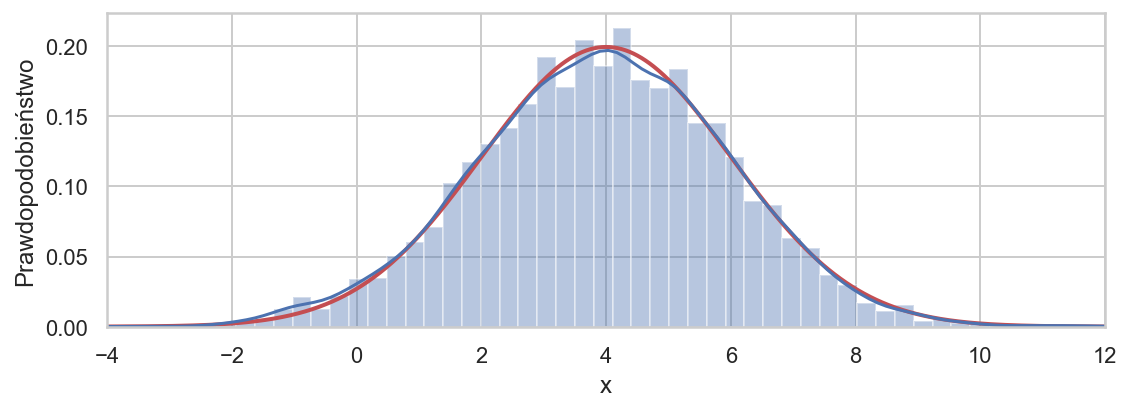

In [21]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(x, y, 'r', lw=2)
sns.distplot(X, ax=ax)
ax.set_xlim(-4, 12)
ax.set_xlabel("x")
ax.set_ylabel("Prawdopodobieństwo")
fig.tight_layout()
fig.savefig("ch16-normal-distribution-sampled.pdf")

/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


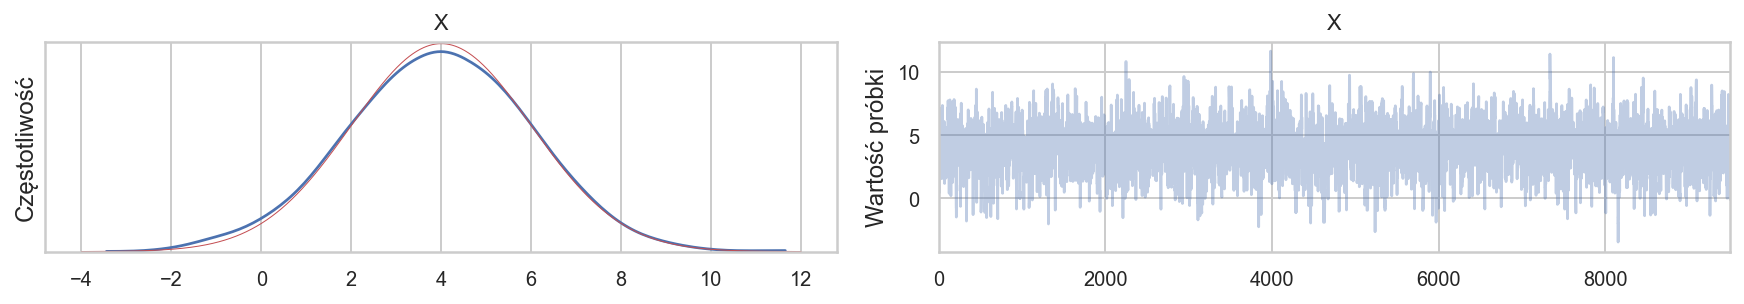

In [22]:
axes=mc.traceplot(trace)
axes[0,0].plot(x, y, 'r', lw=0.5)
axes[0,0].set_ylabel("Częstotliwość")
axes[0,1].set_ylabel("Wartość próbki")
fig.tight_layout()
fig.savefig("ch16-normal-sampling-trace.png")
fig.savefig("ch16-normal-sampling-trace.pdf")

## Zależne zmienne losowe

In [23]:
model = mc.Model()

In [24]:
with model:
    mean = mc.Normal('mean', 3.0)
    sigma = mc.HalfNormal('sigma', sd=1.0)
    X = mc.Normal('X', mean, tau=sigma)

In [25]:
model.vars

[mean, sigma_log__, X]

In [26]:
with model:
    start = mc.find_MAP()

logp = -2.4949, ||grad|| = 0.13662: 100%|██████████| 7/7 [00:00<00:00, 1630.21it/s]


In [27]:
start

{'mean': array(3.),
 'sigma_log__': array(-0.34657365),
 'X': array(3.),
 'sigma': array(0.70710674)}

In [28]:
with model:
    step = mc.Metropolis()
    trace = mc.sample(9500, start=start, step=step, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [X]
>Metropolis: [sigma]
>Metropolis: [mean]
Sampling chain 0, 0 divergences: 100%|██████████| 10000/10000 [00:02<00:00, 3335.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [29]:
trace.get_values('sigma').mean()

0.8075603668039698

In [30]:
X = trace.get_values('X')

In [31]:
X.mean()

2.928365993128997

In [32]:
trace.get_values('X').std()

2.1930421325449134

/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (9500) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


[Text(0, 0.5, 'Wartość próbki'),
 Text(0, 0.5, 'Wartość próbki'),
 Text(0, 0.5, 'Wartość próbki')]

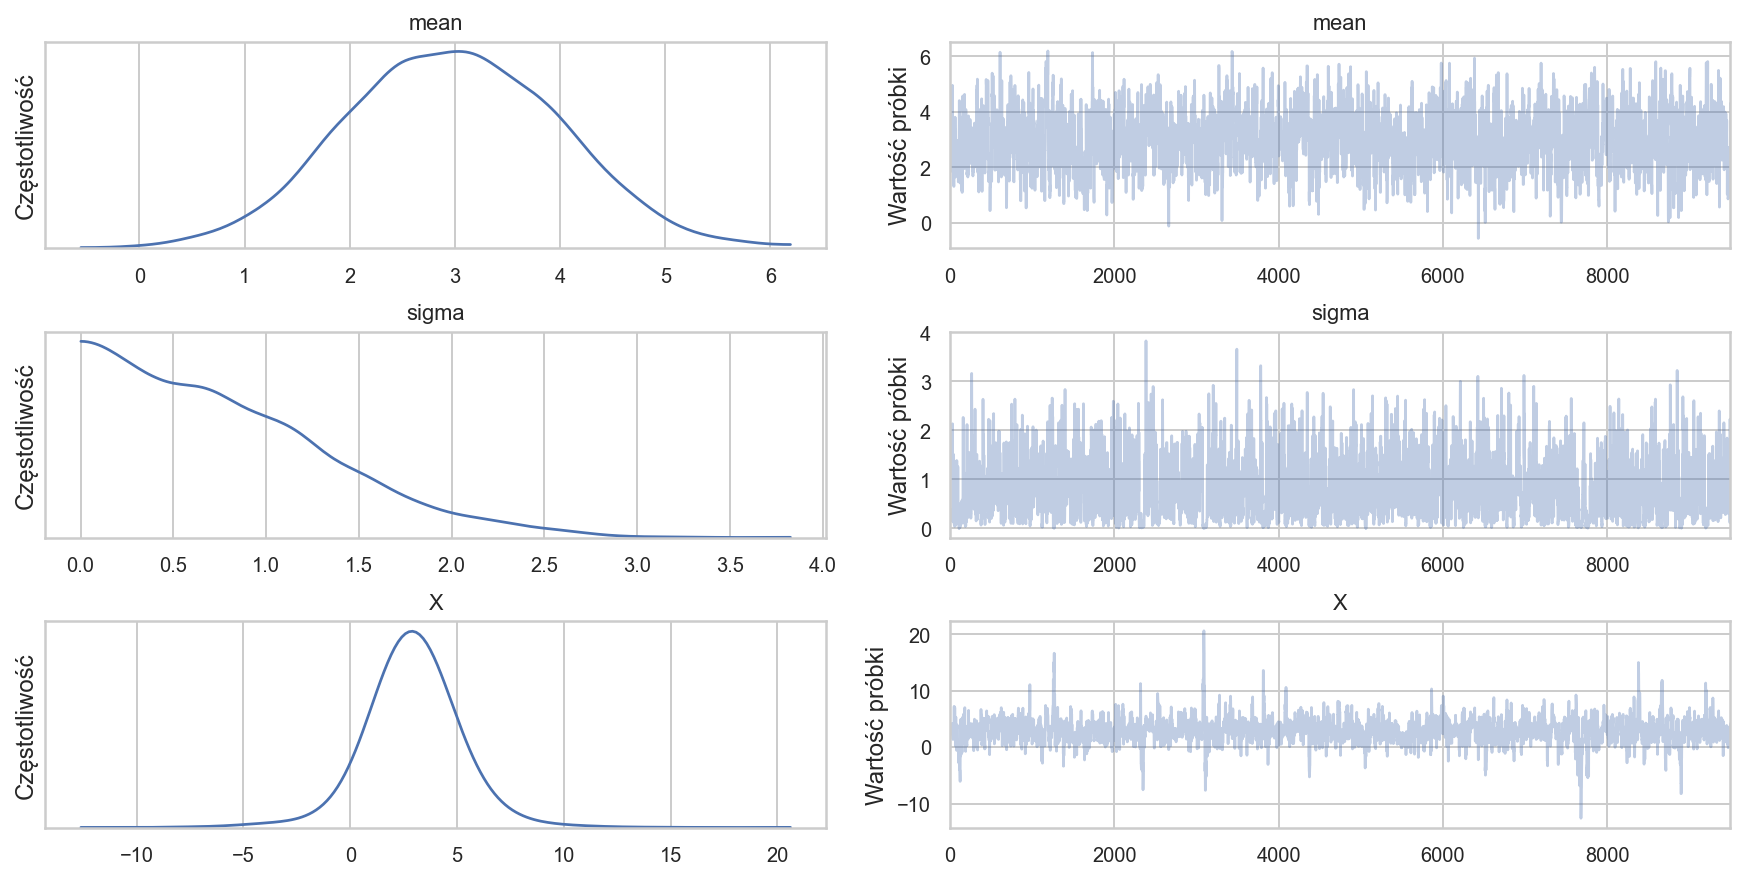

In [33]:
axes = mc.traceplot(trace, var_names=['mean', 'sigma', 'X'])
[axes[i,0].set_ylabel("Częstotliwość") for i in range(0,3)]
[axes[i,1].set_ylabel("Wartość próbki") for i in range(0,3)] 


## Rozkłady a posteriori

In [34]:
mu = 2.5

In [35]:
s = 1.5

In [36]:
data = stats.norm(mu, s).rvs(100)

In [37]:
with mc.Model() as model:
    
    mean = mc.Normal('mean', 4.0, tau=1.0) # Prawdziwa wartość 2,5
    sigma = mc.HalfNormal('sigma', tau=3.0 * np.sqrt(np.pi/2)) # Prawdziwa wartość 1,5

    X = mc.Normal('X', mean, tau=1/sigma**2, observed=data)

In [38]:
model.vars

[mean, sigma_log__]

In [39]:
with model:
    start = mc.find_MAP()
    step = mc.Metropolis()
    trace = mc.sample(6000, start=start, step=step, chains=1)
    #step = mc.NUTS()
    #trace = mc.sample(10000, start=start, step=step)

logp = -195.31, ||grad|| = 0.0043242: 100%|██████████| 13/13 [00:00<00:00, 1672.01it/s]  
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mean]
Sampling chain 0, 0 divergences: 100%|██████████| 6500/6500 [00:01<00:00, 4598.71it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [40]:
start

{'mean': array(2.54695401),
 'sigma_log__': array(0.42991421),
 'sigma': array(1.53712564)}

In [41]:
model.vars

[mean, sigma_log__]

/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (6000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


[Text(0, 0.5, 'Wartość próbki'), Text(0, 0.5, 'Wartość próbki')]

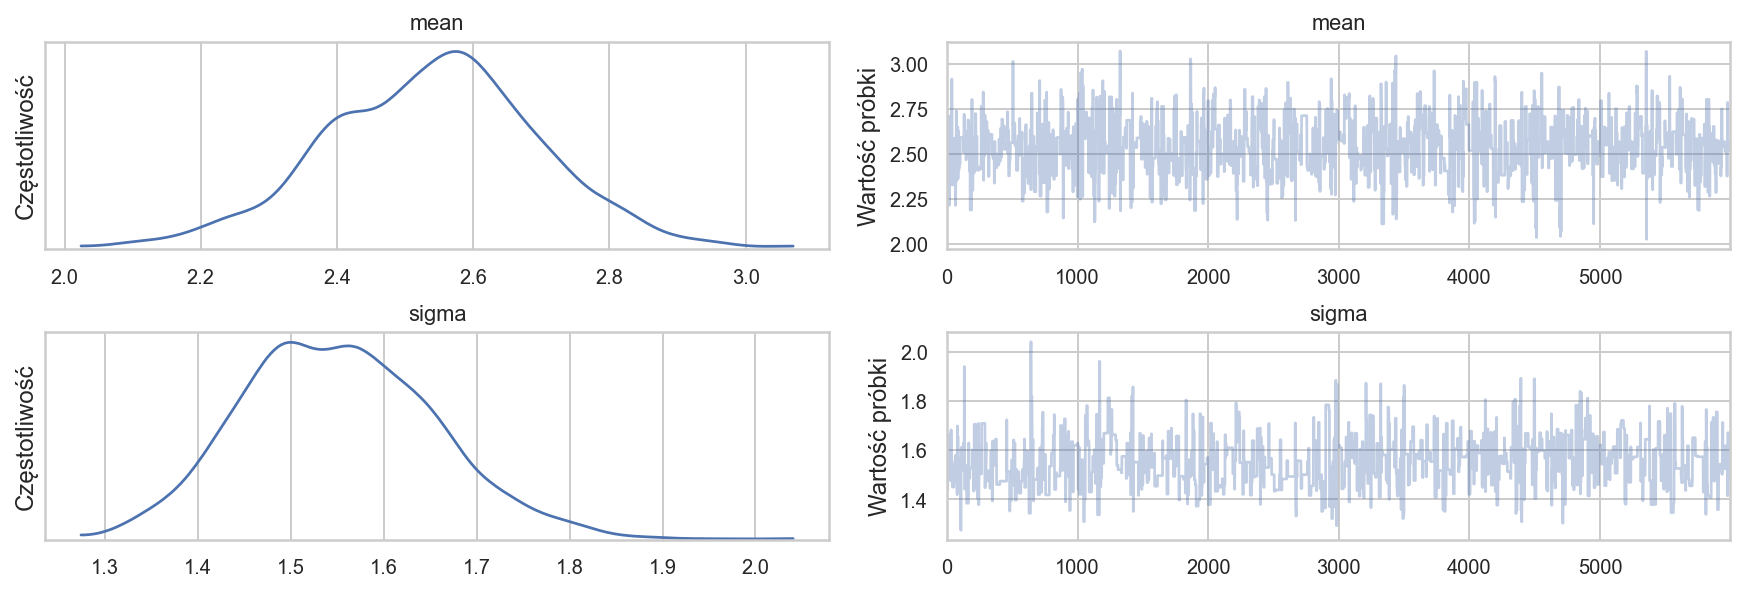

In [42]:
axes=mc.traceplot(trace, var_names=['mean', 'sigma'])
[axes[i,0].set_ylabel("Częstotliwość") for i in range(0,2)]
[axes[i,1].set_ylabel("Wartość próbki") for i in range(0,2)]
 


In [43]:
mu, trace.get_values('mean').mean()

(2.5, 2.540419299936615)

In [44]:
s, trace.get_values('sigma').mean()

(1.5, 1.5529249434629795)

/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (6000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Text(0.5, 1.0, '94% przedział ufności')

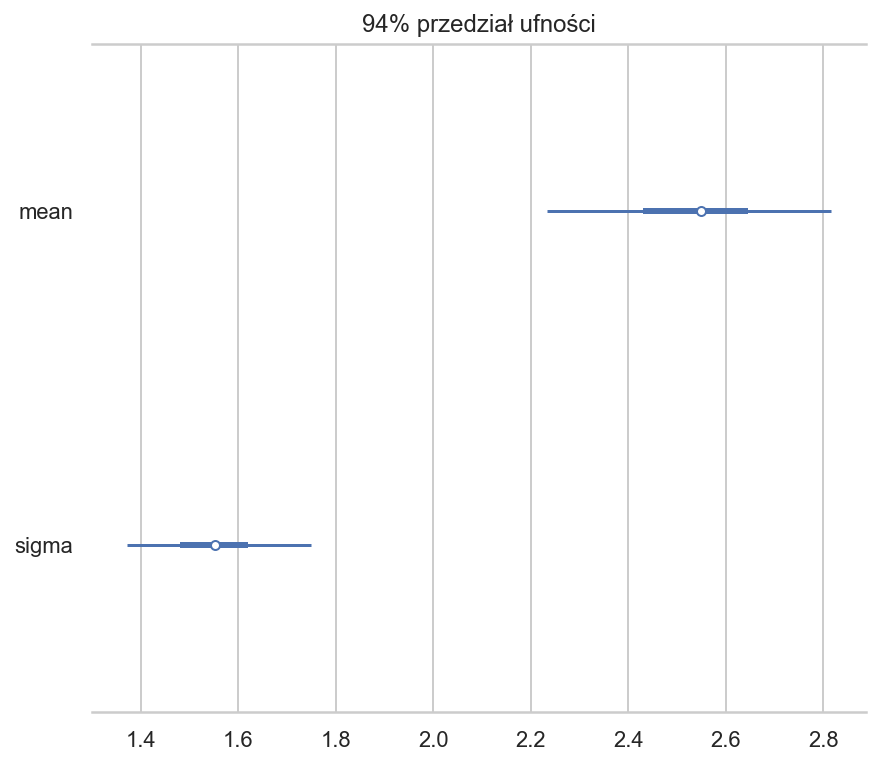

In [45]:
gs = mc.forestplot(trace, var_names=['mean', 'sigma'])
gs[0].set_title("94% przedział ufności")

In [46]:
help(mc.summary)

Help on function summary in module arviz.stats.stats:

summary(data, var_names: Union[List[str], NoneType] = None, fmt: str = 'wide', kind: str = 'all', round_to=None, include_circ=None, stat_funcs=None, extend=True, credible_interval=0.94, order='C', index_origin=0, coords: Union[Dict[str, List[Any]], NoneType] = None, dims: Union[Dict[str, List[str]], NoneType] = None) -> Union[pandas.core.frame.DataFrame, xarray.core.dataset.Dataset]
    Create a data frame with summary statistics.
    
    Parameters
    ----------
    data : obj
        Any object that can be converted to an az.InferenceData object
        Refer to documentation of az.convert_to_dataset for details
    var_names : list
        Names of variables to include in summary
    fmt : {'wide', 'long', 'xarray'}
        Return format is either pandas.DataFrame {'wide', 'long'} or xarray.Dataset {'xarray'}.
    kind : {'all', 'stats', 'diagnostics'}
        Whether to include the `stats`: `mean`, `sd`, `hpd_3%`, `hpd_97%`, 

In [47]:
mc.summary(trace, var_names=['mean', 'sigma'])

/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (6000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 6000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 6000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,2.540,0.156,2.234,2.816,0.006,0.004,781.0,781.0,780.0,564.0,NaN
sigma,1.553,0.103,1.372,1.749,0.005,0.003,463.0,463.0,468.0,488.0,NaN


## Regresja liniowa

In [48]:
dataset = sm.datasets.get_rdataset("Davis", "carData")

In [49]:
data = dataset.data[dataset.data.sex == 'M']

In [50]:
data = data[data.weight < 110]

In [51]:
data.head(3)

,sex,weight,height,repwt,repht
0,M,77,182,77.0,180.0
3,M,68,177,70.0,175.0
5,M,76,170,76.0,165.0


In [52]:
model = smf.ols("height ~ weight", data=data)

In [53]:
result = model.fit()

In [54]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     41.35
Date:                Sun, 25 Oct 2020   Prob (F-statistic):           7.11e-09
Time:                        14:04:06   Log-Likelihood:                -268.20
No. Observations:                  87   AIC:                             540.4
Df Residuals:                      85   BIC:                             545.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.6173      3.987     38.281      0.0

In [55]:
x = np.linspace(50, 110, 25)

In [56]:
y = result.predict({"weight": x})

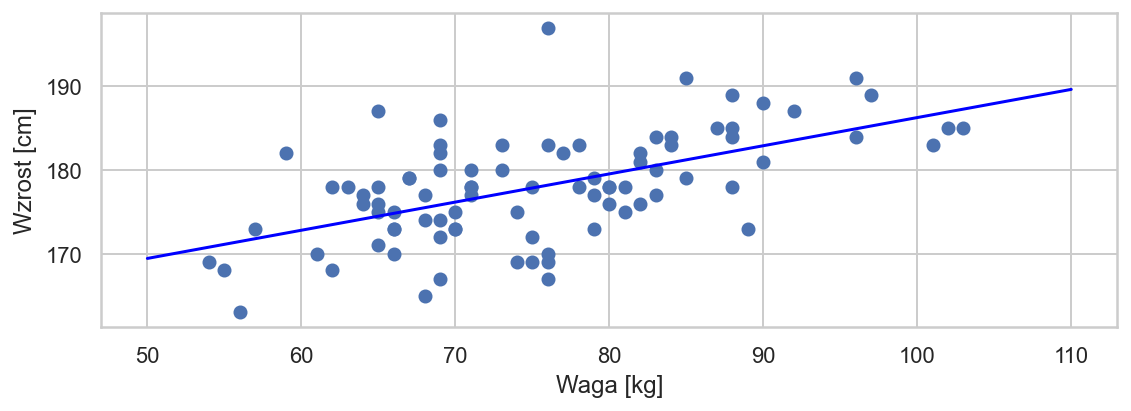

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, color="blue")
ax.set_xlabel("Waga [kg]")
ax.set_ylabel("Wzrost [cm]")
fig.tight_layout()
fig.savefig("ch16-linear-ols-fit.pdf")

In [58]:
with mc.Model() as model:
    sigma = mc.Uniform('sigma', 0, 10)
    intercept = mc.Normal('intercept', 125, sd=30)
    beta = mc.Normal('beta', 0, sd=5)
    height_mu = intercept + beta * data.weight
    mc.Normal('height', mu=height_mu, sd=sigma, observed=data.height)
    predict_height = mc.Normal('predict_height', mu=intercept + beta * x, sd=sigma, shape=len(x)) 

In [59]:
model.vars

[sigma_interval__, intercept, beta, predict_height]

In [60]:
# help(mc.NUTS)

In [61]:
with model:
    start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(9500, step, start=start, chains=1)

logp = -382.7, ||grad|| = 9.9702: 100%|██████████| 37/37 [00:00<00:00, 2164.52it/s]   
Sequential sampling (1 chains in 1 job)
NUTS: [predict_height, beta, intercept, sigma]
Sampling chain 0, 0 divergences: 100%|██████████| 10000/10000 [00:44<00:00, 224.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [62]:
model.vars

[sigma_interval__, intercept, beta, predict_height]

/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


[Text(0, 0.5, 'Wartość próbki'), Text(0, 0.5, 'Wartość próbki')]

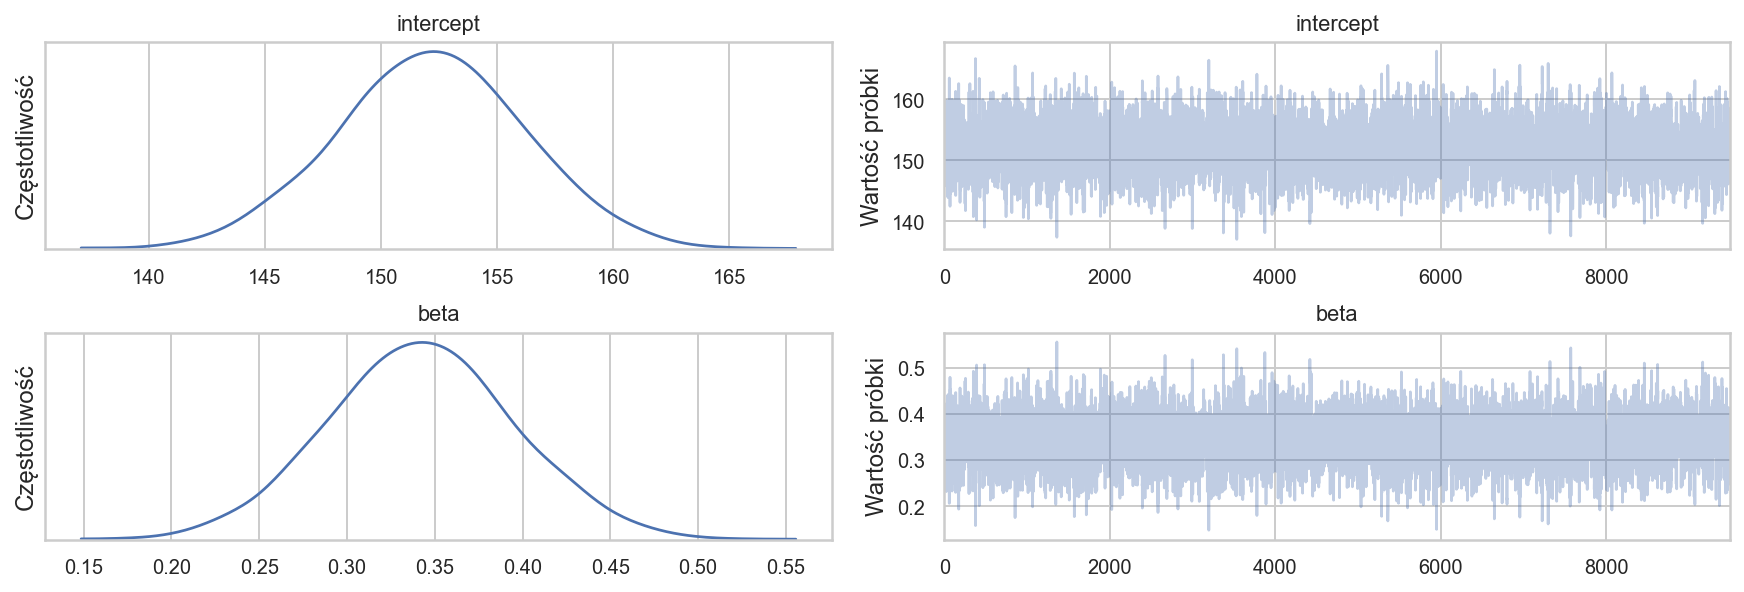

In [63]:
axes = mc.traceplot(trace, var_names=['intercept', 'beta'])
[axes[i,0].set_ylabel("Częstotliwość") for i in range(0,2)]
[axes[i,1].set_ylabel("Wartość próbki") for i in range(0,2)] 

In [64]:
intercept = trace.get_values("intercept").mean()
intercept

152.153633795305

In [65]:
beta = trace.get_values("beta").mean()
beta

0.34251409828022533

In [66]:
result.params

Intercept    152.617348
weight         0.336477
dtype: float64

In [67]:
result.predict({"weight": 90})

0    182.9003
dtype: float64

In [68]:
weight_index = np.where(x == 90)[0][0]

In [69]:
trace.get_values("predict_height")[:, weight_index].mean()

183.05544826675575

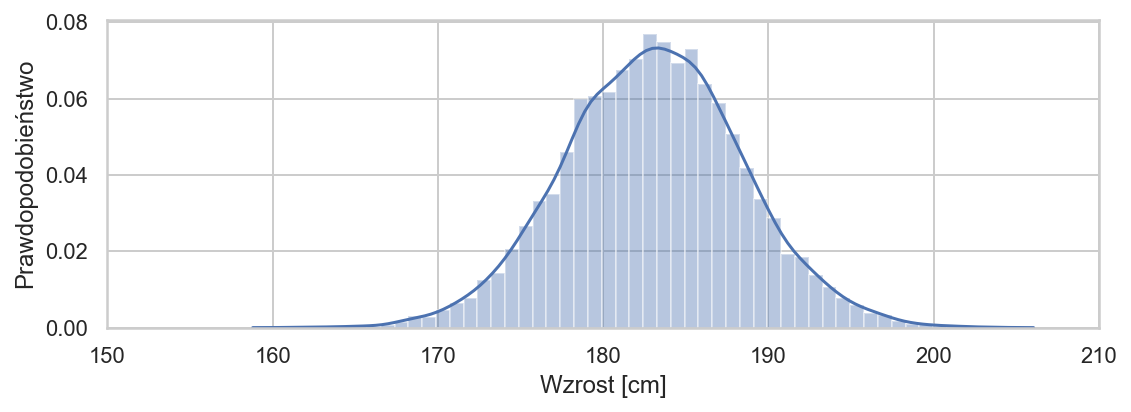

In [70]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.distplot(trace.get_values("predict_height")[:, weight_index], ax=ax)
ax.set_xlim(150, 210)
ax.set_xlabel("Wzrost [cm]")
ax.set_ylabel("Prawdopodobieństwo")
fig.tight_layout()
fig.savefig("ch16-linear-model-predict-cut.pdf")

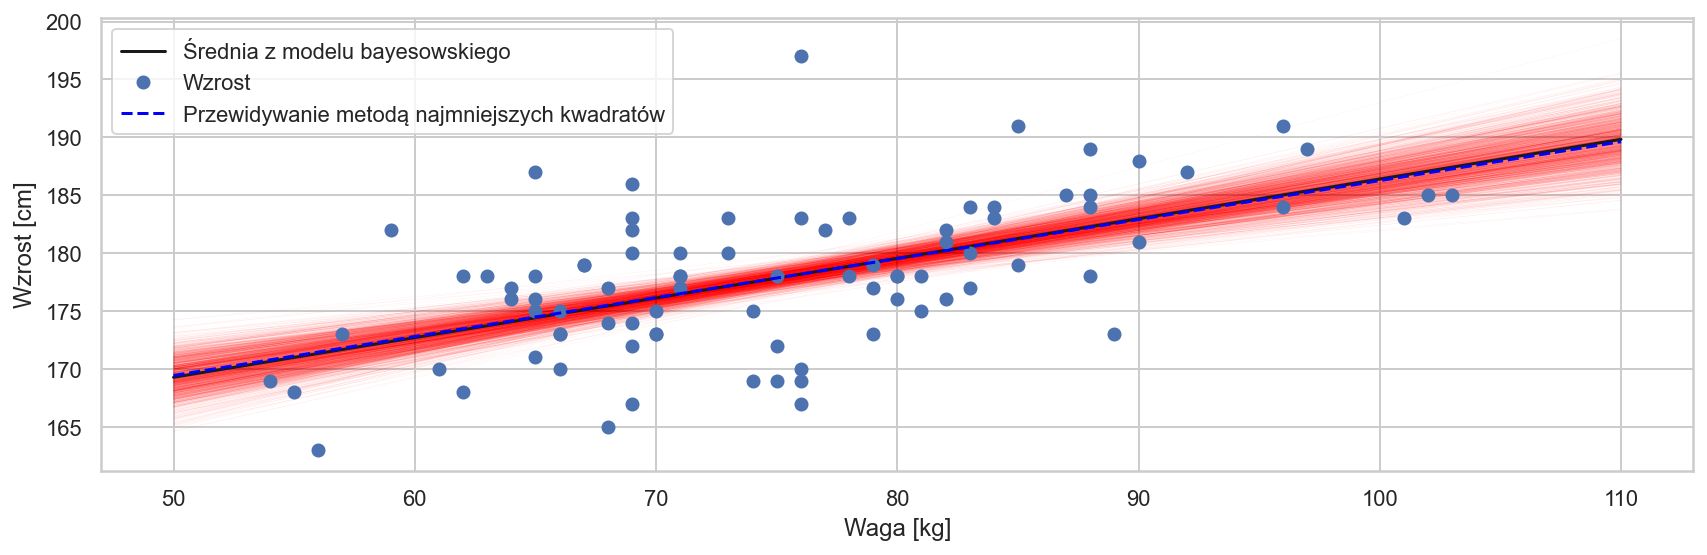

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for n in range(500, 2000, 1):
    intercept = trace.get_values("intercept")[n]
    beta = trace.get_values("beta")[n]
    ax.plot(x, intercept + beta * x, color='red', lw=0.25, alpha=0.05)

intercept = trace.get_values("intercept").mean()
beta = trace.get_values("beta").mean()
ax.plot(x, intercept + beta * x, color='k', label="Średnia z modelu bayesowskiego")

ax.plot(data.weight, data.height, 'o', label='Wzrost')
ax.plot(x, y, '--', color="blue", label="Przewidywanie metodą najmniejszych kwadratów")
ax.set_xlabel("Waga [kg]")
ax.set_ylabel("Wzrost [cm]")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch16-linear-model-fit.pdf")
fig.savefig("ch16-linear-model-fit.png")

In [72]:
with mc.Model() as model:
    mc.glm.GLM.from_formula('height ~ weight', data)
    step = mc.NUTS()
    trace = mc.sample(1500, step, chains=1, discard_tuned_samples=False)
help(mc.sample)

Sequential sampling (1 chains in 1 job)
NUTS: [sd, weight, Intercept]
Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [00:06<00:00, 330.73it/s]
The acceptance probability does not match the target. It is 0.9213168263565535, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Help on function sample in module pymc3.sampling:

sample(draws=500, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, cores=None, tune=500, progressbar=True, model=None, random_seed=None, discard_tuned_samples=True, compute_convergence_checks=True, **kwargs)
    Draw samples from the posterior using the given step methods.
    
    Multiple step methods are supported via compound step methods.
    
    Parameters
    ----------
    draws : int
        The number of samples to draw. Defaults to 500. The number of tuned samples are discarded
        by default. See ``discard_tuned_samples``.
    init : str
        Initialization method to use for auto-assigned NUTS samplers.
    
        * auto : Choose a default initialization method automatically.
          Currently, this is ``'jitter+adapt_diag'``, but this can change in the future.
          If you depend on the exact behaviour, choose an initialization method explicitly.
        * adapt_diag 

/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


[Text(0, 0.5, 'Wartość próbki'),
 Text(0, 0.5, 'Wartość próbki'),
 Text(0, 0.5, 'Wartość próbki')]

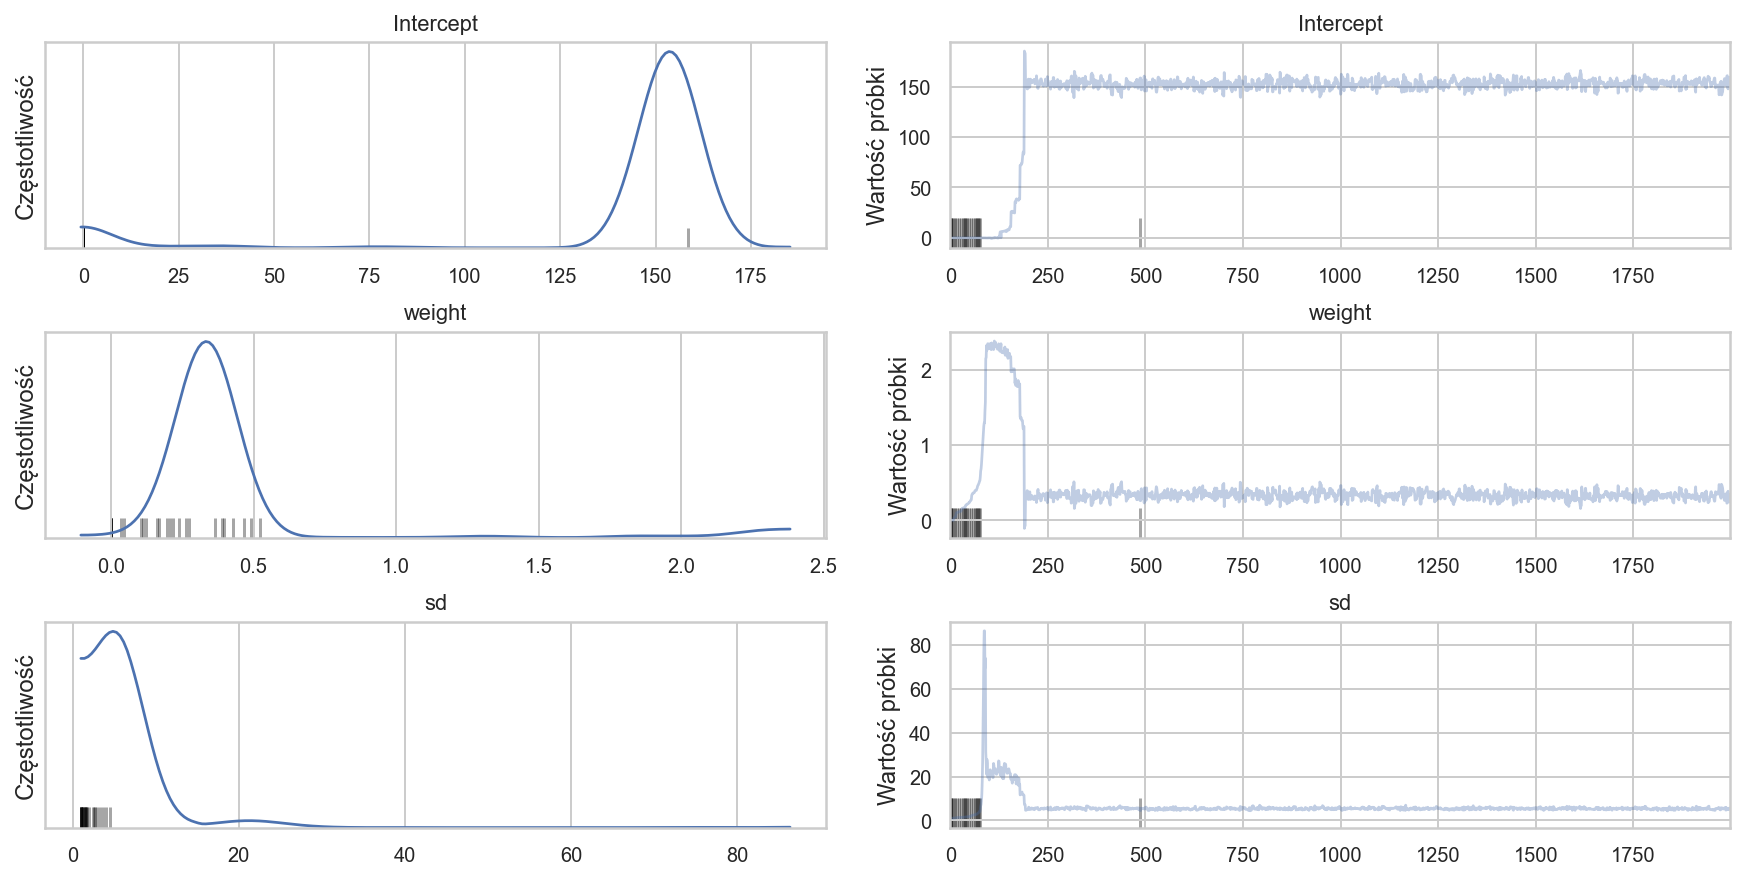

In [73]:
axes = mc.traceplot(trace, var_names=['Intercept', 'weight', 'sd'])
[axes[i,0].set_ylabel("Częstotliwość") for i in range(0,3)]
[axes[i,1].set_ylabel("Wartość próbki") for i in range(0,3)] 

## Modele wielopoziomowe

In [74]:
dataset = sm.datasets.get_rdataset("Davis", "carData")

In [75]:
data = dataset.data.copy()
data = data[data.weight < 110]

In [76]:
data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0)

In [77]:
data.head()

,sex,weight,height,repwt,repht
0,0,77,182,77.0,180.0
1,1,58,161,51.0,159.0
2,1,53,161,54.0,158.0
3,0,68,177,70.0,175.0
4,1,59,157,59.0,155.0


In [78]:
with mc.Model() as model:

    intercept_mu, intercept_sigma = 125, 30
    beta_mu, beta_sigma = 0.0, 5.0
    
    intercept = mc.Normal('intercept', intercept_mu, sd=intercept_sigma, shape=2)
    beta = mc.Normal('beta', beta_mu, sd=beta_sigma, shape=2)
    error = mc.Uniform('error', 0, 10)


    sex_idx = data.sex.values
    height_mu = intercept[sex_idx] + beta[sex_idx] * data.weight

    mc.Normal('height', mu=height_mu, sd=error, observed=data.height)

In [79]:
model.vars

[intercept, beta, error_interval__]

In [80]:
with model:
    start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(5000, step, start=start, chains=1)

logp = -618.03, ||grad|| = 8.8049: 100%|██████████| 51/51 [00:00<00:00, 2067.56it/s]  
Sequential sampling (1 chains in 1 job)
NUTS: [error, beta, intercept]
Sampling chain 0, 0 divergences: 100%|██████████| 5500/5500 [00:21<00:00, 258.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/arviz/plo

[Text(0, 0.5, 'Wartość próbki'),
 Text(0, 0.5, 'Wartość próbki'),
 Text(0, 0.5, 'Wartość próbki')]

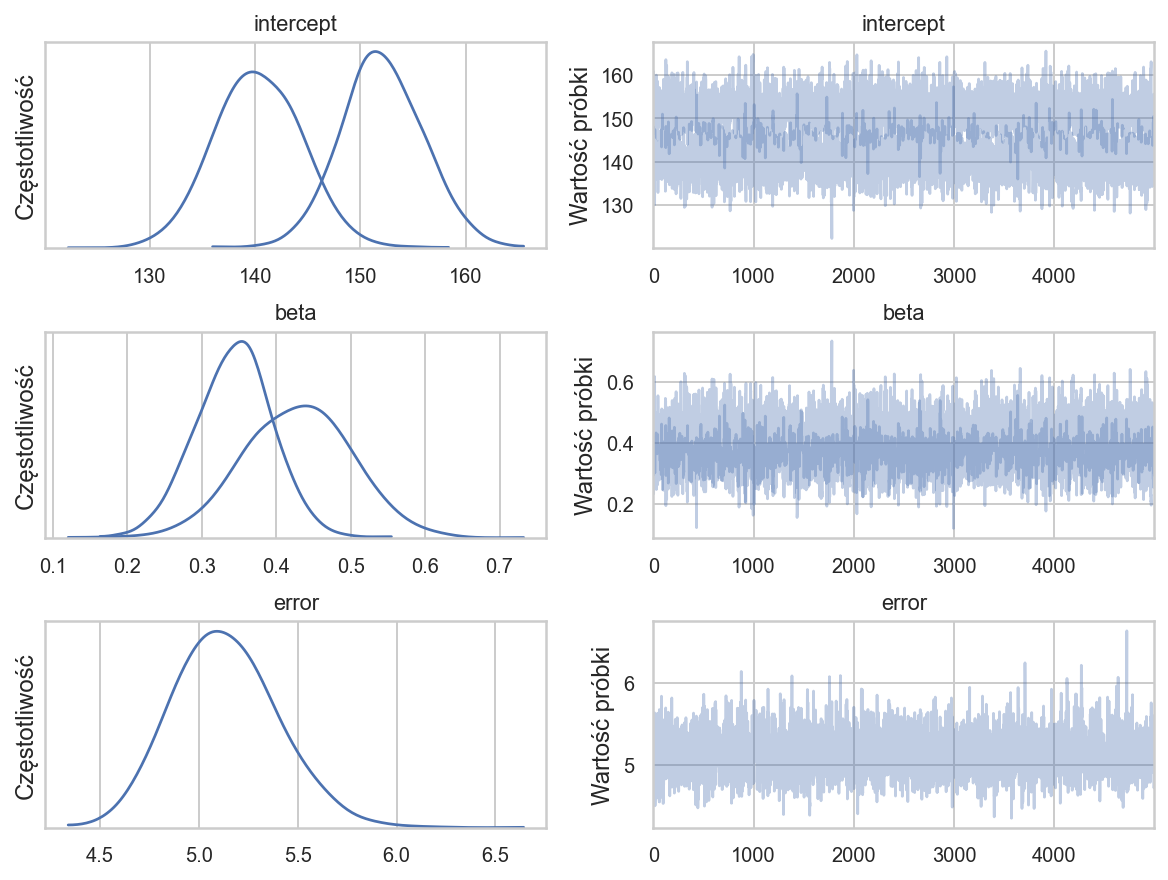

In [81]:
axes = mc.traceplot(trace, figsize=(8,6))
[axes[i,0].set_ylabel("Częstotliwość") for i in range(0,3)]
[axes[i,1].set_ylabel("Wartość próbki") for i in range(0,3)] 

In [82]:
intercept_m, intercept_f = trace.get_values('intercept').mean(axis=0)

In [83]:
intercept = trace.get_values('intercept').mean()

In [84]:
beta_m, beta_f = trace.get_values('beta').mean(axis=0)

In [85]:
beta = trace.get_values('beta').mean()

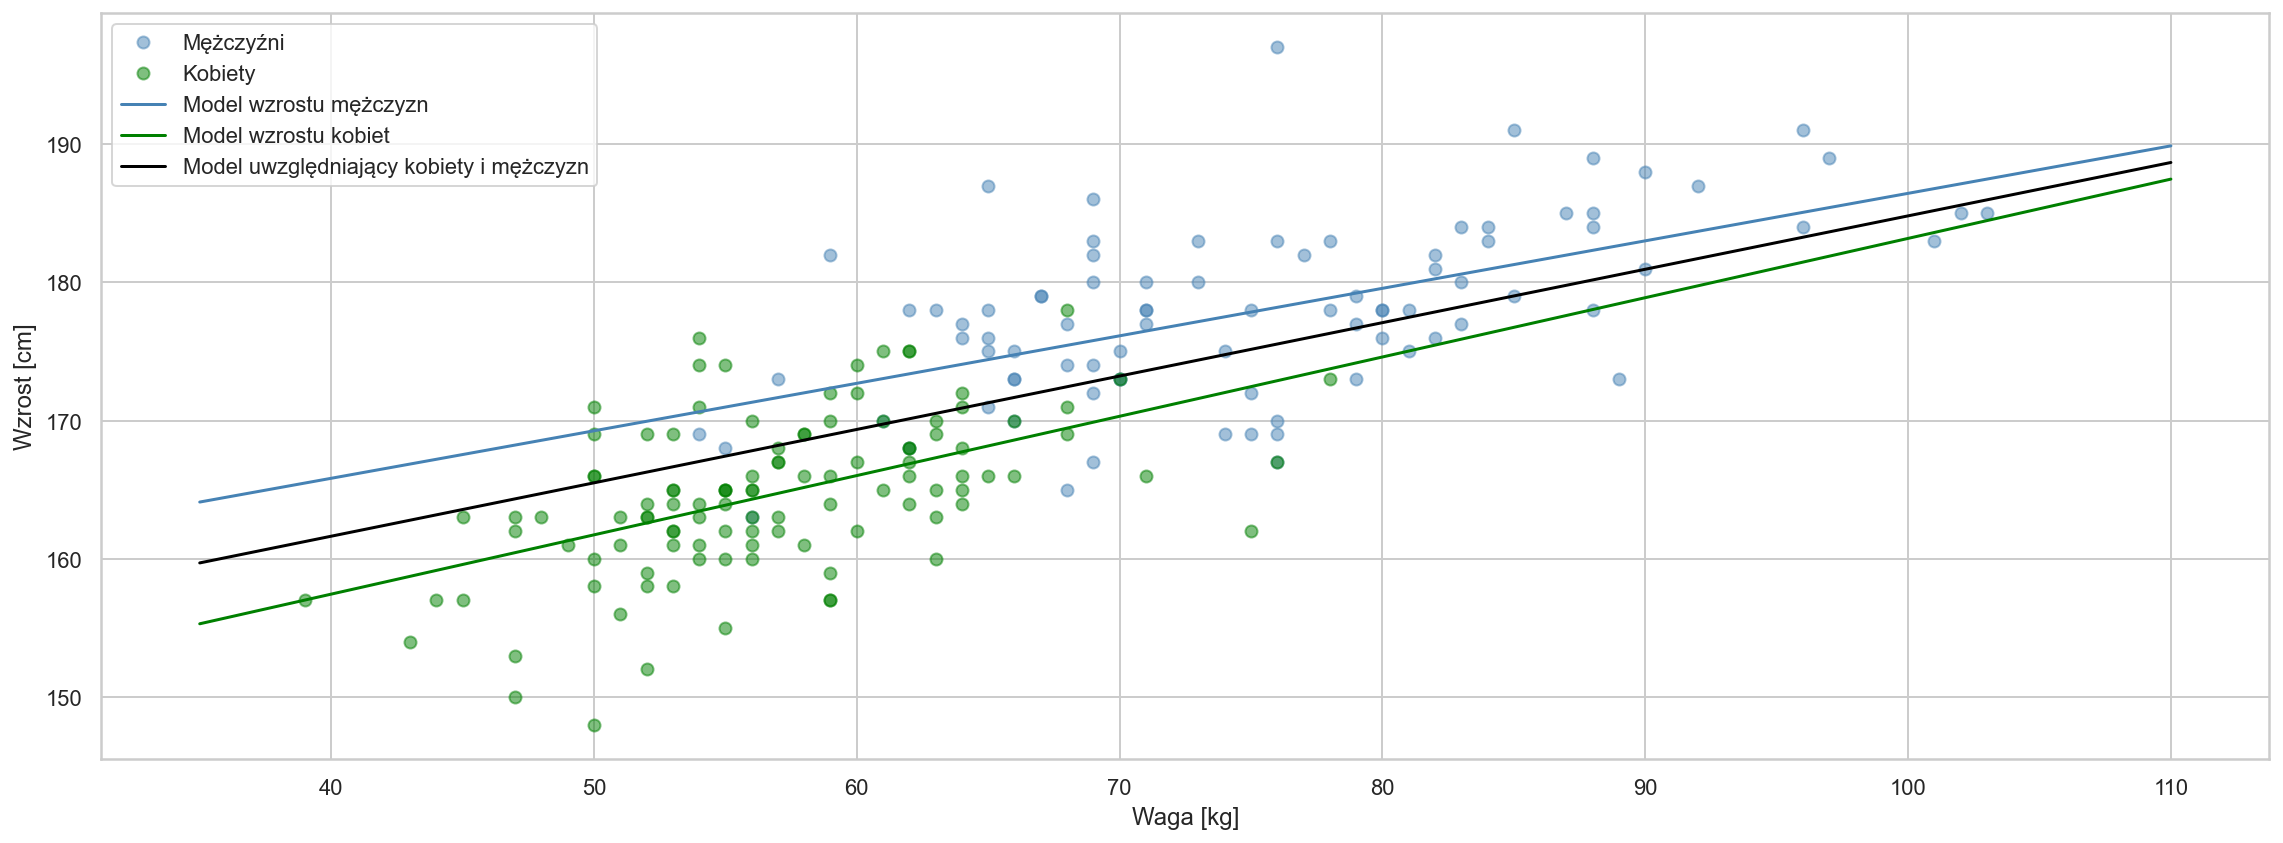

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

mask_m = data.sex == 0
mask_f = data.sex == 1

ax.plot(data.weight[mask_m], data.height[mask_m], 'o', color="steelblue", label="Mężczyźni", alpha=0.5)
ax.plot(data.weight[mask_f], data.height[mask_f], 'o', color="green", label="Kobiety", alpha=0.5)

x = np.linspace(35, 110, 50)
ax.plot(x, intercept_m + x * beta_m, color="steelblue", label="Model wzrostu mężczyzn")
ax.plot(x, intercept_f + x * beta_f, color="green", label="Model wzrostu kobiet")
ax.plot(x, intercept + x * beta, color="black", label="Model uwzględniający kobiety i mężczyzn")

ax.set_xlabel("Waga [kg]")
ax.set_ylabel("Wzrost [cm]")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch16-multilevel-linear-model-fit.pdf")
fig.savefig("ch16-multilevel-linear-model-fit.png")

In [87]:
trace.get_values('error').mean()

5.137353609914419